# 0) Setup and load data

In [81]:
import os
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, recall_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

DATA_PATH = os.path.join("..", "data", "hotel_bookings_clean.csv")

df = pd.read_csv(DATA_PATH)
df.shape, df.columns[:10]


((119210, 37),
 Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
        'arrival_date_month', 'arrival_date_week_number',
        'arrival_date_day_of_month', 'stays_in_weekend_nights',
        'stays_in_week_nights', 'adults'],
       dtype='object'))

# 1) Feature engineering

In [82]:
df_model = df.copy()

#basic target
y = df_model["is_canceled"].astype(float)

#simple, stable features (mostly numeric)
df_model["total_guests"] = (
    df_model.get("adults", 0).fillna(0)
    + df_model.get("children", 0).fillna(0)
    + df_model.get("babies", 0).fillna(0)
)

#binary encode hotel type (City=1, Resort=0)
df_model["hotel_city"] = (df_model["hotel"] == "City Hotel").astype(int)
feature_cols = [
    "lead_time",
    "adr",
    "stays_in_week_nights",
    "stays_in_weekend_nights",
    "total_guests",
    "hotel_city",
    "previous_cancellations",
    "booking_changes"
]

X_df = df_model[feature_cols].copy()

#quickly hande missing values
X_df = X_df.replace([np.inf, -np.inf], np.nan)
mask = X_df.notna().all(axis=1) & y.notna()

X = X_df.loc[mask].to_numpy(dtype=float)
y = y.loc[mask].to_numpy(dtype=float)

X.shape, y.shape

((119210, 8), (119210,))

# 2) Train/test split

In [83]:
#1) reproducible shuffle
rng = np.random.default_rng(42)
n = X.shape[0]
idx = rng.permutation(n)

#2) train/test split (80/20)
split = int(0.8 * n)
train_idx = idx[:split]
test_idx = idx[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

#3) z-score standardization
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0)
sigma[sigma == 0] = 1.0

X_train_s = (X_train - mu) / sigma
X_test_s = (X_test - mu) / sigma

#4) intercept (design matrix)
X_train_design = np.column_stack([np.ones(X_train_s.shape[0]), X_train_s])
X_test_design = np.column_stack([np.ones(X_test_s.shape[0]), X_test_s])

print("Design shapes:", X_train_design.shape, X_test_design.shape)
print("First row (train):", X_train_design[0])



Train shapes: (95368, 8) (95368,)
Test shapes: (23842, 8) (23842,)
Design shapes: (95368, 9) (23842, 9)
First row (train): [ 1.          0.4001907  -0.60175265  1.32105599  1.08154438  0.03916451
 -1.40883658 -0.10325622 -0.34116687]


# 3) Fit a NumPy Linear Model

In [84]:
#fit model using least squares: minimize squared errors
beta, residuals, ran, s = np.linalg.lstsq(X_train_design, y_train, rcond=None)

#predictions on train and test
y_pred_train = X_train_design @ beta
y_pred_test = X_test_design @ beta

#quick sanity checks (first 5 predictions)
print("beta shape:", beta.shape)
print("First 5 train predictions:", y_pred_train[:5])
print("First 5 test predictions: ", y_pred_test[:5])

#clip predictions to [0,1] for interpretability
y_pred_test_clipped = np.clip(y_pred_test, 0, 1)
print("Test predictions clipped range:", y_pred_test_clipped.min(), y_pred_test_clipped.max())


beta shape: (9,)
First 5 train predictions: [0.35859901 0.08483993 0.37441866 0.30191773 0.30437075]
First 5 test predictions:  [0.37637164 0.58999538 0.44977255 0.43697456 0.4338385 ]
Test predictions clipped range: 0.0 1.0


In [85]:
#evaluation metrics
def mse(y_true, y_pred):                
    return np.mean((y_true - y_pred) ** 2)

def r2(y_true, y_pred):             #how much of the variance is explained by the model
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

#model performance
train_mse = mse(y_train, y_pred_train)          #how the model adapts to training data
test_mse = mse(y_test, y_pred_test)             #how good the model generalizes

train_r2 = r2(y_train, y_pred_train)
test_r2 = r2(y_test, y_pred_test)

#baseline model
baseline_pred_train = np.full_like(y_train, y_train.mean())             #use a naive model, always predicts the same value
baseline_pred_test = np.full_like(y_test, y_train.mean())

baseline_train_mse = mse(y_train, baseline_pred_train)              #check how good is the model compared to baseline
baseline_test_mse = mse(y_test, baseline_pred_test)

lpm_metrics = {
    "Train MSE": [round(train_mse, 4)],
    "Test MSE": [round(test_mse, 4)],
    "Train R²": [round(train_r2, 4)],
    "Test R²": [round(test_r2, 4)],
    "Baseline Train MSE": [round(baseline_train_mse, 4)],
    "Baseline Test MSE": [round(baseline_test_mse, 4)],
    
}

pd.DataFrame(lpm_metrics, index=["Linear Probability Model"])



,Train MSE,Test MSE,Train R²,Test R²,Baseline Train MSE,Baseline Test MSE
Linear Probability Model,0.2031,0.2037,0.1292,0.1285,0.2332,0.2337


**Linear Probability Model Interpretation**

The linear probability model serves as a simple and interpretable baseline for analyzing cancellation behavior. It outperforms a naive mean-based baseline, indicating that booking characteristics contain useful predictive information, although overall predictive performance remains limited due to the binary nature of the target. Consequently, the model is primarily valuable for understanding the direction and relative importance of key features rather than for accurate individual-level prediction.

# 4) Logistic Regression for Cancellation Prediction

To complement the linear probability model, we fit a logistic regression model to predict booking cancellations. Logistic regression is more appropriate for binary outcomes, as it directly models probabilities in the [0,1] interval and often provides improved predictive performance. The goal of this section is to assess whether a more flexible model can outperform the linear model in terms of prediction accuracy.

In [86]:
#Fit logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_s, y_train)                  #learn connection between features and cancellation probability using sigmoid function

#Predictions
y_pred_test_lr = logreg.predict(X_test_s)               #retuns class probabilities (0 or 1)
y_prob_test_lr = logreg.predict_proba(X_test_s)[:, 1]       #returns predicted cancellation probabilities

#Evaluation metrics
acc = accuracy_score(y_test, y_pred_test_lr)
auc = roc_auc_score(y_test, y_pred_test_lr)             #how good does the model separate between cancelled and not-cancelled bookings

logreg_metrics = {
    "Test Accuracy": [round(acc, 4)],
    "Test AUC": [round(auc, 4)],
    "Recall (Canceled=1)": [round(
        recall_score(y_test, y_pred_test_lr, pos_label=1)
    , 4)]
}

pd.DataFrame(logreg_metrics, index=["Logistic Regression"])


,Test Accuracy,Test AUC,Recall (Canceled=1)
Logistic Regression,0.6966,0.6277,0.3572


**Logistic Regression Results Interpretation**

The logistic regression model achieves a test accuracy of 0.70 and an AUC of 0.632, indicating moderate predictive performance. The model correctly identifies most non-canceled bookings, but has lower recall for canceled bookings, reflecting the inherent difficulty of predicting cancellations. Overall, logistic regression provides improved and more realistic predictions compared to the linear probability model.

# 5) Random Forest Classifier

In [87]:
#Fit Random Forest
rf = RandomForestClassifier(
    n_estimators=300,                       #number of trees
    max_depth=15,                           #decreases overfitting
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_s, y_train)                

#Predictions
y_pred_test_rf = rf.predict(X_test_s)              
y_prob_test_rf = rf.predict_proba(X_test_s)[:, 1]       

#Evaluation
acc_rf = accuracy_score(y_test, y_pred_test_rf)
auc_rf = roc_auc_score(y_test, y_pred_test_rf)
recall_rf_1 = recall_score(y_test, y_pred_test_rf, pos_label=1)              

rf_metrics = pd.DataFrame({
    "Test Accuracy": [round(acc_rf, 4)],
    "Test AUC": [round(auc_rf, 4)],
    "Recall (Canceled=1)": [round(recall_rf_1, 4)]
}, index=["Random Forest (tuned)"])

rf_metrics

#print("Random Forest Performance (Test set):")
#print(f"Accuracy: {acc_rf:.3f}")
#print(f"AUC:      {auc_rf:.3f}")

#print("\nClassification Report:")
#print(classification_report(y_test, y_pred_test_rf))

#Feature importances
#importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)           #how much every variable affects decrease in impurity
#print("\nTop feature importances:")
#print(importances.head(10))


,Test Accuracy,Test AUC,Recall (Canceled=1)
Random Forest (tuned),0.7691,0.7108,0.4818


In [88]:
# Classification report
report_rf = classification_report(y_test, y_pred_test_rf, output_dict=True)
report_rf_df = pd.DataFrame(report_rf).T.round(4)

report_rf_df


,precision,recall,f1-score,support
0.0,0.7534,0.9397,0.8363,14961.0000
1.0,0.8259,0.4818,0.6086,8881.0000
accuracy,0.7691,0.7691,0.7691,0.7691
macro avg,0.7896,0.7108,0.7224,23842.0000
weighted avg,0.7804,0.7691,0.7515,23842.0000


In [89]:
rf_importances = (
    pd.Series(rf.feature_importances_, index=feature_cols)
      .sort_values(ascending=False)
      .round(4)
      .to_frame(name="Importance")
)

rf_importances  


,Importance
lead_time,0.3885
adr,0.1867
previous_cancellations,0.1849
booking_changes,0.0975
stays_in_week_nights,0.0486
hotel_city,0.0335
total_guests,0.0331
stays_in_weekend_nights,0.0273


The random forest model achieves the strongest predictive performance and improves recall for canceled bookings. Feature importance analysis consistently identifies lead time, previous cancellations, and ADR as the most important drivers of cancellations.

In [90]:
#tuning of max depth parameter
results = []

for depth in [8, 10, 12, 15]:
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=depth,
        min_samples_leaf=20,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_s, y_train)
    y_prob = rf.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    results.append((depth, auc))

results


[(8, 0.7833137579844742),
 (10, 0.7979177344035604),
 (12, 0.8113786532971312),
 (15, 0.8280656306253633)]

A limited hyperparameter search over the maximum tree depth shows a consistent improvement in AUC as model complexity increases. The random forest with max_depth = 15 achieves the best performance, indicating that non-linear effects and feature interactions play an important role in cancellation prediction. No clear signs of overfitting are observed within the tested range.

# 6) Model comparison

In [94]:
comparison = pd.DataFrame({
    "Model": [
        "Linear Probability Model (NumPy)",
        "Logistic Regression",
        "Random Forest (tuned)"
    ],
    "Metrics": [
        "Test MSE = 0.2037, Test R² = 0.1285",     
        "Test Accuracy = 0.6966, Test AUC = 0.6277", 
        "Test Accuracy = 0.7691, Test AUC = 0.7108"  
    ],
    "Best For": [
        "Interpretability (direction of effects)",
        "Simple prediction + probability estimates",
        "Best predictive performance"
    ],
    "Key Notes": [
        "Outperforms baseline MSE (mean predictor)",
        "Struggles to recall cancellations (class 1)",
        "Improves recall for cancellations + captures non-linearity"
    ]
})

comparison


,Model,Metrics,Best For,Key Notes
0,Linear Probability Model (NumPy),"Test MSE = 0.2037, Test R² = 0.1285",Interpretability (direction of effects),Outperforms baseline MSE (mean predictor)
1,Logistic Regression,"Test Accuracy = 0.6966, Test AUC = 0.6277",Simple prediction + probability estimates,Struggles to recall cancellations (class 1)
2,Random Forest (tuned),"Test Accuracy = 0.7691, Test AUC = 0.7108",Best predictive performance,Improves recall for cancellations + captures n...


# 7) Visual Model Diagnostics

## 7.1) ROC Curve

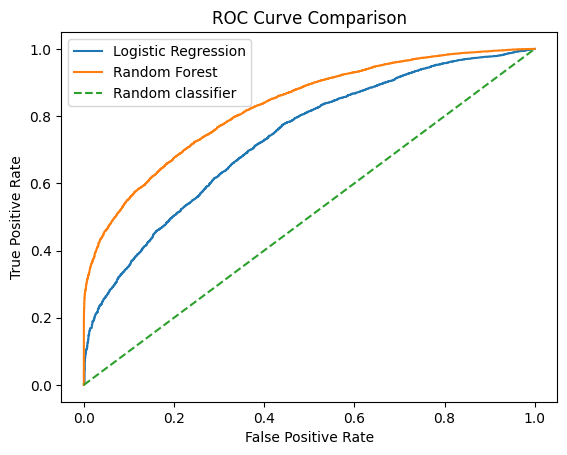

In [92]:
# ROC curve values
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_test_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_test_rf)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


The ROC curves show that the random forest consistently outperforms logistic regression across classification thresholds, resulting in a higher AUC and better discrimination between canceled and non-canceled bookings.

## 7.2) Confusion Matrix

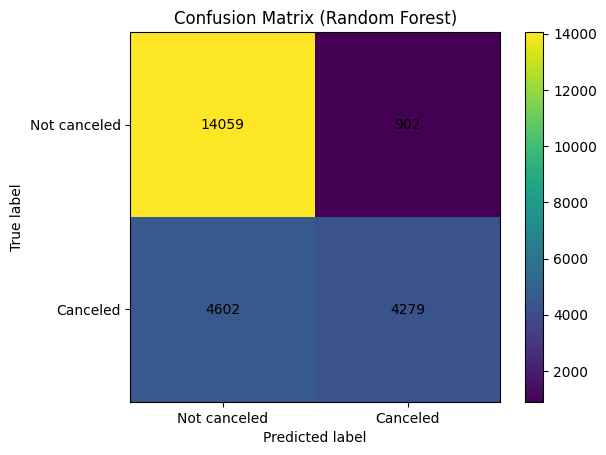

In [93]:
cm = confusion_matrix(y_test, y_pred_test_rf)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Random Forest)")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")

ticks = np.arange(2)
plt.xticks(ticks, ["Not canceled", "Canceled"])
plt.yticks(ticks, ["Not canceled", "Canceled"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()

The confusion matrix shows that the random forest model correctly identifies most non-canceled bookings, resulting in high overall accuracy. Approximately 48% of canceled bookings are correctly detected, while a substantial number of cancellations remain misclassified as non-canceled. This reflects a conservative prediction strategy that prioritizes avoiding false alarms over capturing all cancellations, highlighting a trade-off between recall and precision in cancellation prediction.

# 8) Business Insights & Recommendations

Lead time is the strongest predictor of cancellations. Bookings made far in advance show a significantly higher cancellation risk, suggesting that hotels could apply stricter cancellation policies or targeted reminders for long lead-time reservations.

Past cancellation behavior is highly informative. Guests with previous cancellations are more likely to cancel again, indicating potential value in customer-level risk scoring or differentiated booking conditions.

Non-linear effects play an important role. The random forest model substantially outperforms linear and logistic models, highlighting complex interactions between booking characteristics that simpler models fail to capture.

Cancellation prediction involves a trade-off between recall and false alarms. While the model achieves good overall accuracy, a notable share of cancellations remains undetected, suggesting that threshold tuning or cost-sensitive strategies may be needed depending on business priorities.

Predictive models can support operational decision-making. Accurate cancellation risk estimates can inform overbooking strategies, targeted incentives, and capacity planning, ultimately reducing revenue loss from last-minute cancellations.